
# NAR–SPEI–NARX Hybrid Forecasting model of Soil Moisture Index (SMI)  
## Novi Sad measuring station
**Dataset:** `data.xlsx` (high-frequency observations of SM, P, T)  


## Overview of the Proposed Architecture
We implement the following three-stage hybrid architecture:

**Stage 1 (NAR):** Univariate forecasting of precipitation and temperature  

**Stage 2 (Index Transformation):** Computation of a SPEI index from *forecasted* (P_hat) and (T_hat).  

**Stage 3 (NARX):** Hybrid forecasting of \(SMI\) using past \(SMI\) (feedback) and lagged \(SPEI\) (exogenous input):


## Train/Test Protocol
- **Train:** all samples with timestamp **2019-12-31**
- **Test:** all samples in **2020**
- **Evaluation metric:** coefficient of determination \(R^2\) and RMSE
- **Operational (causal) setup:** when predicting at time \(t\), the model uses **observed** past \(SMI\) (available in real-time monitoring) and **forecasted** past climate-derived inputs \(SPEI\) computed from Stage 1 forecasts.


### Import libraries, load data and creating column time

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


# 1) Load data

PATH = r"F:\D DIK RECOVER\Radovi Naucni\mathematics\baza\kod\data.xlsx"
df = pd.read_excel(PATH)

# Parse timestamps (format: "dd.mm.yyyy. HH:MM:SS")
df["Time"] = pd.to_datetime(df["Time"], format="%d.%m.%Y. %H:%M:%S", errors="coerce")
df = df.dropna(subset=["Time"]).sort_values("Time").set_index("Time")

# Keep relevant columns
df = df[["SM", "P", "T"]].astype(float)

print("Date range:", df.index.min(), "→", df.index.max())
print("Total rows:", len(df))
df.head(5)
df.describe()

Date range: 2014-01-01 00:39:14 → 2020-12-30 23:32:15
Total rows: 62234


,SM,P,T
count,62234.000000,62234.000000,62234.000000
mean,22.111734,0.049015,12.796372
std,3.878846,0.448457,9.351554
min,11.986000,0.000000,-19.450000
25%,18.769000,0.000000,5.550000
50%,23.124000,0.000000,12.770000
75%,25.064000,0.000000,19.440000
max,31.835000,23.800000,41.110000


### Exploratory plots (SM, P, T)

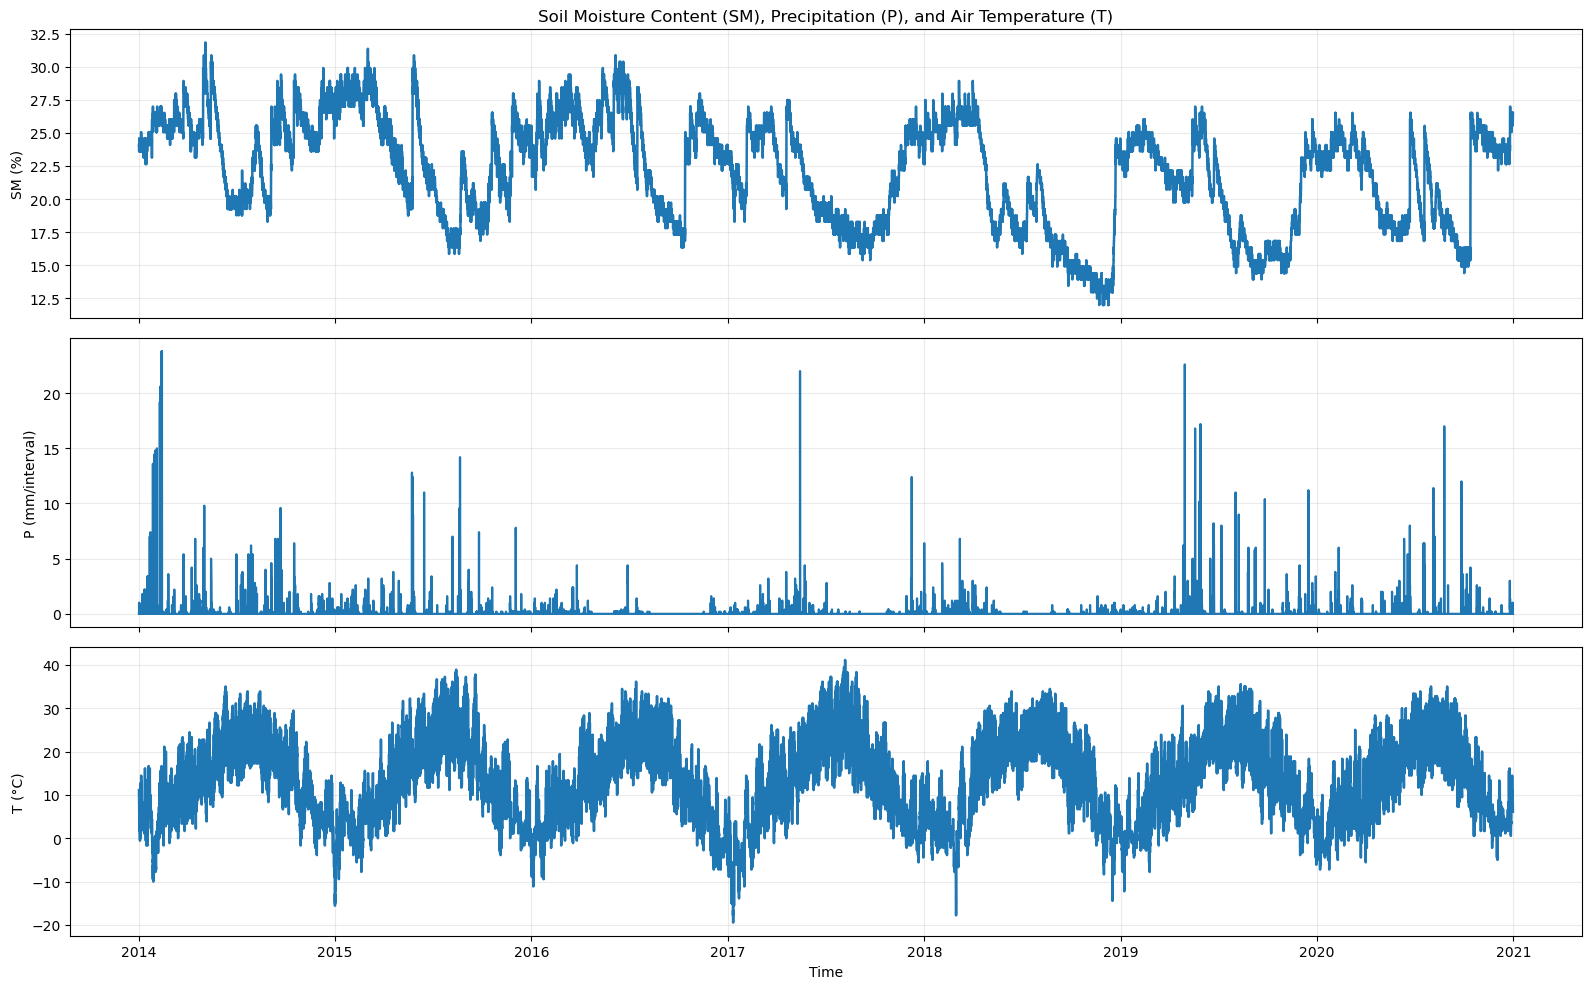

In [2]:
import matplotlib.dates as mdates

# Load raw observations
data_path = PATH
df_raw = pd.read_excel(data_path)

# Parse timestamp 
df_raw['Time'] = pd.to_datetime(df_raw['Time'], errors='coerce', dayfirst=True)
df_raw = df_raw.dropna(subset=['Time']).sort_values('Time').reset_index(drop=True)

# Ensure numeric columns
for col in ['SM','P','T']:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')

# Plot as three aligned panels
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True)

axes[0].plot(df_raw['Time'], df_raw['SM'], linewidth=1.8)
axes[0].set_ylabel('SM (%)')
axes[0].set_title('Soil Moisture Content (SM), Precipitation (P), and Air Temperature (T)')
axes[0].grid(True, which='major', linestyle='-', alpha=0.25)

axes[1].plot(df_raw['Time'], df_raw['P'], linewidth=1.6)
axes[1].set_ylabel('P (mm/interval)')
axes[1].grid(True, which='major', linestyle='-', alpha=0.25)

axes[2].plot(df_raw['Time'], df_raw['T'], linewidth=1.8)
axes[2].set_ylabel('T (°C)')
axes[2].set_xlabel('Time')
axes[2].grid(True, which='major', linestyle='-', alpha=0.25)

# Improve date ticks
locator = mdates.AutoDateLocator(minticks=6, maxticks=12)
formatter = mdates.ConciseDateFormatter(locator)
axes[2].xaxis.set_major_locator(locator)
axes[2].xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()


### Dividing dataset into two subsets; train where is year <= 2019, test where is year = 2020

In [3]:
train = df[df.index.year <= 2019].copy()
test  = df[df.index.year == 2020].copy()

print("Train samples:", len(train))
print("Test samples:", len(test))

Train samples: 53398
Test samples: 8836


##  Soil Moisture Index (SMI) 
Computing \(SMI\) as a standardized anomaly (z-score) using **training-period** statistics only:

In [4]:
mu_sm = train["SM"].mean()
sd_sm = train["SM"].std(ddof=1)

df["SMI"] = (df["SM"] - mu_sm) / sd_sm
print("mu_sm:", train["SM"].mean())
print("sd_sm:", train["SM"].std(ddof=1))

mu_sm: 22.229802913964903
sd_sm: 3.9792953185648337



# Stage 1 — Univariate Forecasting (NAR) for P and T
Fitting two separate nonlinear autoregressive (NAR) models for precipitation and temperature and produce
multi-step recursive forecasts for the entire test horizon (2020).


In [5]:
# Helper utilities for NAR

from numpy.lib.stride_tricks import sliding_window_view

def make_lag_matrix(arr, lags):
    X = sliding_window_view(arr, lags)[:-1]
    y = arr[lags:]
    return X, y

def fit_nar(series, lags=48, hidden=(64, 32), max_iter=40, random_state=42):
    arr = series.values.astype(float)
    X, y = make_lag_matrix(arr, lags)
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=hidden,
            activation="relu",
            solver="adam",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=max_iter,
            random_state=random_state,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=5
        )) #To approximate the nonlinear mapping,it is used an MLPRegressor.
    ])
    model.fit(X, y)
    return model

def recursive_forecast(model, history, steps, lags):
    hist = history.astype(float).copy()
    preds = np.empty(steps, dtype=float)
    for i in range(steps):
        x = hist[-lags:].reshape(1, -1)
        preds[i] = model.predict(x)[0]
        hist = np.append(hist, preds[i])
    return preds


# Fitting NAR models for P and T

LAGS_PT = 48
nar_P = fit_nar(train["P"], lags=LAGS_PT)
nar_T = fit_nar(train["T"], lags=LAGS_PT)

# Forecast 2020 horizon
P_hat_2020 = recursive_forecast(nar_P, train["P"].values, len(test), LAGS_PT)
T_hat_2020 = recursive_forecast(nar_T, train["T"].values, len(test), LAGS_PT)

P_hat = pd.Series(P_hat_2020, index=test.index, name="P_hat")
T_hat = pd.Series(T_hat_2020, index=test.index, name="T_hat")

print("Preview forecasts:")
display(pd.concat([test[["P","T"]].head(), P_hat.head(), T_hat.head()], axis=1))


Preview forecasts:


,P,T,P_hat,T_hat
Time,,,,
2020-01-01 00:48:54,0.0,-1.12,-0.148172,-1.576218
2020-01-01 01:46:57,0.0,-1.12,0.051111,-1.856319
2020-01-01 02:45:59,0.0,-0.56,0.061028,-2.086955
2020-01-01 03:44:01,0.0,-0.56,0.012759,-2.235993
2020-01-01 04:43:03,0.0,-0.56,-0.055724,-2.282703



# Stage 2 — Build SPEI index from forecasted P,T
We compute (SPEI) from the forecasted climate series.


In [6]:
K = 0.05         # temperature-to-demand scaling (proxy)
WINDOW = 720     # ~30 days if sampling is ~hourly

def water_balance(P, T, k=K):
    return P - k * np.maximum(T, 0.0)

# Assemble full P,T series: observed in train, forecasted in test
P_full = pd.concat([train["P"], P_hat])
T_full = pd.concat([train["T"], T_hat])

D_full = pd.Series(water_balance(P_full.values, T_full.values), index=P_full.index, name="D")
D_acc = D_full.rolling(WINDOW).sum()

# Standardize using TRAIN statistics only
D_acc_train = D_acc.loc[train.index].dropna()
mu_D = D_acc_train.mean()
sd_D = D_acc_train.std(ddof=1)

SPEI = (D_acc - mu_D) / sd_D
SPEI.name = "SPEI"

print("SPEI train mean/std:", float(mu_D), float(sd_D))

SPEI train mean/std: -439.2006874159143 274.49330794976635



# Stage 3 — NARX for SMI (feedback + exogenous SPEI)
The NARX model predicts \(SMI_t\) from past observed \(SMI\) and lagged SPEI inputs (derived from Stage 1 forecasts).


In [7]:
# Build NARX features and fit model

LAGS_SMI = 48
LAGS_X   = 48

SMI = df["SMI"].copy()
SPEI_all = SPEI.reindex(df.index)

smi_arr = SMI.values.astype(float)
spei_arr = SPEI_all.values.astype(float)

idx = np.arange(len(df.index))
train_end = np.where(df.index <= pd.Timestamp("2019-12-31 23:59:59"))[0][-1]
test_start = np.where(df.index.year == 2020)[0][0]
test_end   = np.where(df.index.year == 2020)[0][-1]

start = max(WINDOW, LAGS_SMI, LAGS_X)
candidates = idx[start:]

mask_target = np.isfinite(smi_arr)
mask_exog   = np.isfinite(spei_arr)
candidates = candidates[mask_target[candidates] & mask_exog[candidates]]

from numpy.lib.stride_tricks import sliding_window_view
smi_win  = sliding_window_view(smi_arr,  LAGS_SMI)
spei_win = sliding_window_view(spei_arr, LAGS_X)

def build_Xy(t_indices):
    rows_smi = t_indices - LAGS_SMI
    rows_x   = t_indices - LAGS_X
    X = np.hstack([smi_win[rows_smi], spei_win[rows_x]])
    y = smi_arr[t_indices]
    finite = np.isfinite(X).all(axis=1) & np.isfinite(y)
    return X[finite], y[finite]

train_t = candidates[candidates <= train_end]
test_t  = candidates[(candidates >= test_start) & (candidates <= test_end)]

X_train, y_train = build_Xy(train_t)
X_test,  y_test  = build_Xy(test_t)

print("NARX train shape:", X_train.shape, y_train.shape)
print("NARX test shape :", X_test.shape,  y_test.shape)

narx = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=40,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=5
    ))
])

narx.fit(X_train, y_train)


NARX train shape: (52631, 96) (52631,)
NARX test shape : (8836, 96) (8836,)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(early_stopping=True, hidden_layer_sizes=(64, 32),
                              max_iter=40, n_iter_no_change=5,
                              random_state=42))])

## Calculating R^2 and RMSE

In [8]:
# Evaluate on 2020

pred = narx.predict(X_test)

r2 = r2_score(y_test, pred)
rmse = mean_squared_error(y_test, pred, squared=False)

print("Test year 2020 — NAR–SPEI–NARX pipeline")
print(f"R^2:  {r2:.4f}")
print(f"RMSE: {rmse:.4f}")


Test year 2020 — NAR–SPEI–NARX pipeline
R^2:  0.9888
RMSE: 0.0827


## Ploting Observed vs Predicted values

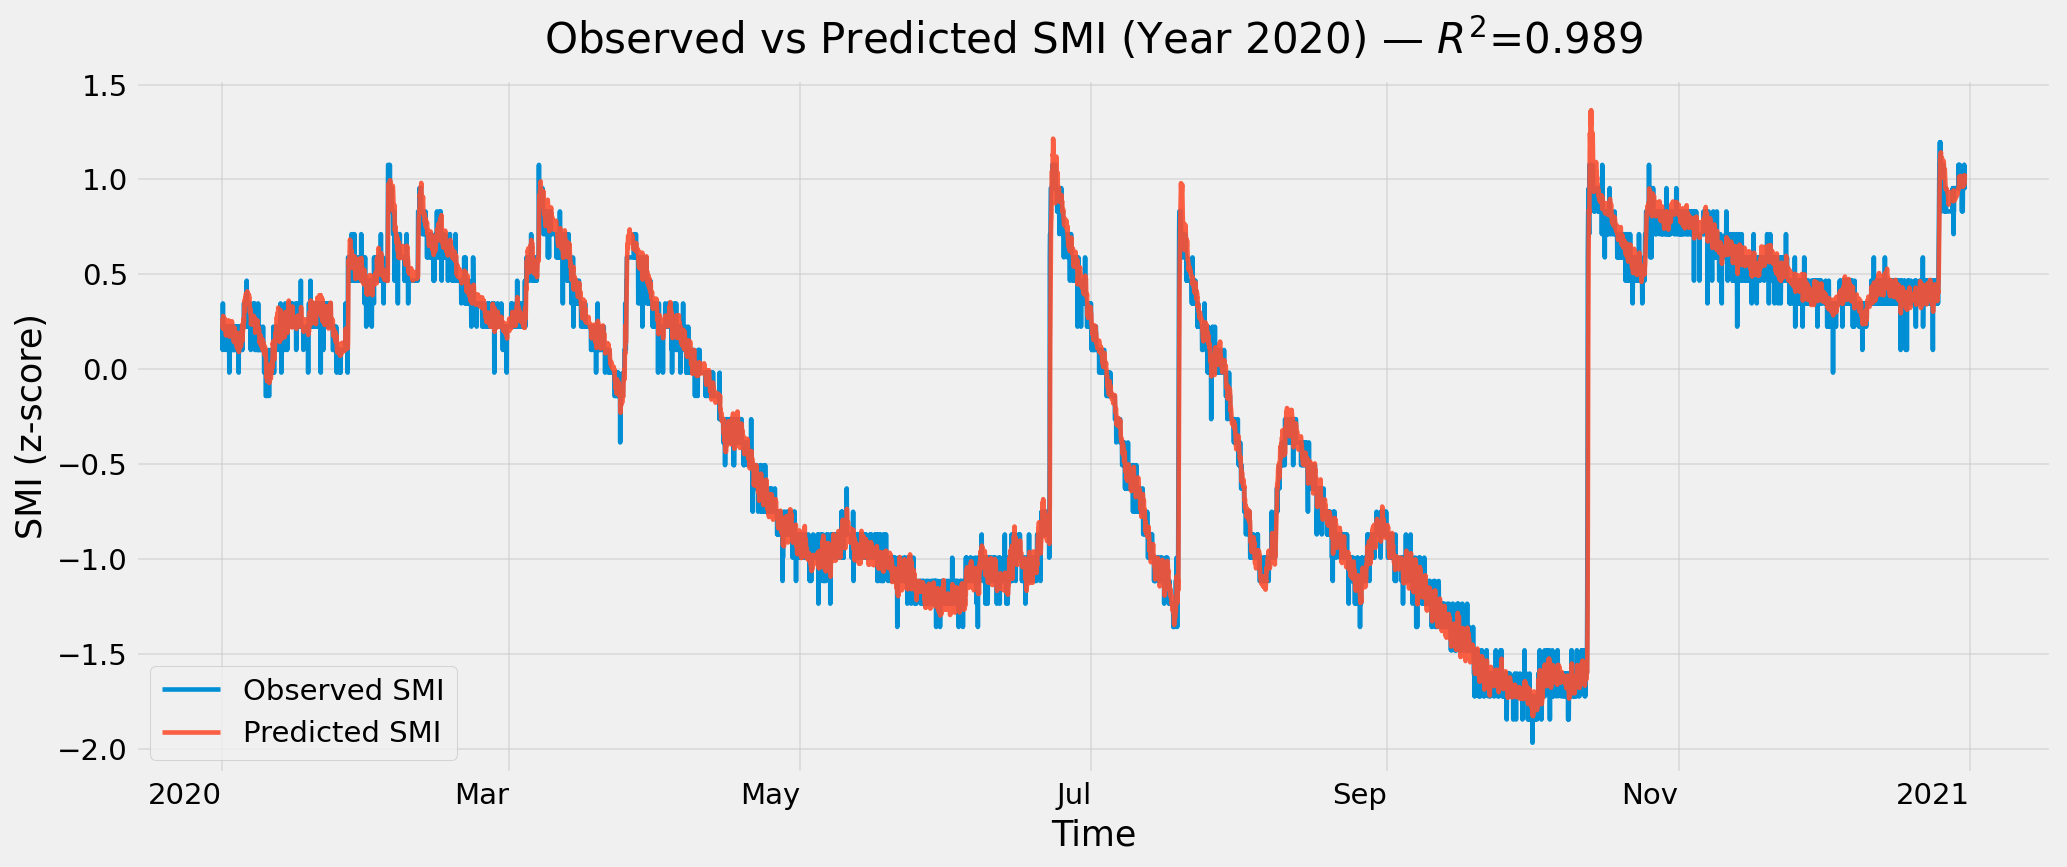

In [10]:
test_times = df.index[test_t][:len(y_test)]

# --- Publication-quality plot (larger + cleaner) ---
import matplotlib.dates as mdates

plt.style.use("fivethirtyeight")

fig, ax = plt.subplots(figsize=(14, 6), dpi=150)

ax.plot(test_times, y_test, label="Observed SMI", linewidth=2.2)
ax.plot(test_times, pred, label="Predicted SMI", linewidth=2.2, alpha=0.9)

ax.set_title(f"Observed vs Predicted SMI (Year 2020) — $R^2$={r2:.3f}", pad=12)
ax.set_xlabel("Time")
ax.set_ylabel("SMI (z-score)")

# Date formatting (works if index is datetime-like)
try:
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    fig.autofmt_xdate(rotation=0)
except Exception:
    pass

ax.grid(True, which="major", linewidth=0.8, alpha=0.6)
ax.legend(frameon=True, loc="best")

fig.tight_layout()
plt.show()


## Interpretation of High R²
This evaluation corresponds to an **operational one-step-ahead** NARX forecast.  
At each timestamp \(t\), the model uses observed \(SMI_{t-1..t-q}\) (available from measurements) and
exogenous inputs computed from Stage 1 forecasts.